### TESTING MODELS WITH 5-FOLD CROSS VALIDATION
* Mollah Lab: CREWdb
* Last Updated: 1/13/23

In [ ]:
#Importing packages
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

### Data Integration

In [ ]:
#Reading in bulk data
data = pd.read_csv("/content/dataset_cleaned_397.csv").rename(columns={'REW (Convert to Numbers)': 'REW'})
data.head()

,ID (REMOVE),SYMBOL,REW,HGNC approved name,Pfam domains,HGNC gene family tag,HGNC gene family description,Function,Modification,Protein complex,Target molecule,Target entity,Product
0,10389,SCML2,Reader,sex comb on midleg-like 2 (Drosophila),"DUF3588 PF12140 353-468, MBT PF02820 67-139 17...",SAMD,Sterile alpha motif (SAM) domain containing,Polycomb group (PcG) protein,#,PRC1,#,#,#
1,22955,SCMH1,Reader,sex comb on midleg homolog 1 (Drosophila),"DUF3588 PF12140 355-469, MBT PF02820 62-134 17...",SAMD,Sterile alpha motif (SAM) domain containing,Polycomb group (PcG) protein,#,PRC1,#,#,#
2,5252,PHF1,Reader,PHD finger protein 1,"Mtf2_C PF14061 525-566, PHD PF00628 89-142, Pf...","TDRD, PHF","Tudor domain containing, Zinc fingers, PHD-type",Polycomb group (PcG) protein,#,PRC2,#,#,#
3,8726,EED,Reader,embryonic ectoderm development,"Pfam-B_26038 PB026038 1-39, Pfam-B_6684 PB0066...",WDR,WD repeat domain containing,Polycomb group (PcG) protein,#,PRC2,#,#,#
4,84181,CHD6,Reader,chromodomain helicase DNA binding protein 6,"BRK PF07533 2400-2441, Chromo PF00385 292-354 ...",#,#,Chromatin remodeling,#,#,chromatin,#,#


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID (REMOVE)                   397 non-null    int64 
 1   SYMBOL                        397 non-null    object
 2   REW                           397 non-null    object
 3   HGNC approved name            397 non-null    object
 4   Pfam domains                  397 non-null    object
 5   HGNC gene family tag          397 non-null    object
 6   HGNC gene family description  397 non-null    object
 7   Function                      393 non-null    object
 8   Modification                  393 non-null    object
 9   Protein complex               392 non-null    object
 10  Target molecule               392 non-null    object
 11  Target entity                 392 non-null    object
 12  Product                       392 non-null    object
dtypes: int64(1), object(

In [ ]:
#Dropping columns 'ID' and 'SYMBOL' because they are not features
data.drop(['ID (REMOVE)', 'SYMBOL', 'HGNC approved name'], axis = 1, inplace = True)
data.replace('#', np.nan, inplace = True)

### Categorical Encoding

In [ ]:
#Checking where all data in the columns are NaN
to_check = data.columns[5:]
data[to_check].isna().all(1).sum()
data.dropna(how='all', subset = to_check, inplace = True)
print('Final Shape of Dataset:', data.shape)
data.replace(np.nan, '-', inplace = True)

Final Shape of Dataset: (393, 10)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   REW                           393 non-null    object
 1   Pfam domains                  393 non-null    object
 2   HGNC gene family tag          393 non-null    object
 3   HGNC gene family description  393 non-null    object
 4   Function                      393 non-null    object
 5   Modification                  393 non-null    object
 6   Protein complex               393 non-null    object
 7   Target molecule               393 non-null    object
 8   Target entity                 393 non-null    object
 9   Product                       393 non-null    object
dtypes: object(10)
memory usage: 33.8+ KB


In [ ]:
#Using one-hot encoding 
from sklearn.preprocessing import OneHotEncoder

X = data.iloc[:, 1:]
print("Number of features used for training :", X.shape[1])
encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)
X_encoded = encoder.fit_transform(X)
print("Training dataset dimensions after one-hot encoding :", X_encoded.shape)

Number of features used for training : 9
Training dataset dimensions after one-hot encoding : (393, 579)


In [ ]:
data["REW"].value_counts()

Writer    153
Reader    136
Eraser    104
Name: REW, dtype: int64

### Class Rebalancing

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter

y_df = data['REW']

X = X_encoded
y = y_df.values

y_ = LabelEncoder().fit_transform(y)
oversample = SMOTE(random_state=42)
X_smote, y_smote = oversample.fit_resample(X, y_)
print("Training dataset dimensions after rebalancing :", X_smote.shape)
print("Labels dimensions after rebalancing :", y_smote.shape)

Training dataset dimensions after rebalancing : (459, 579)
Labels dimensions after rebalancing : (459,)


### Methods for each ML Model

***Deep Neural Net (ANN)***

In [ ]:
from sklearn.neural_network import MLPClassifier

def deepNeuralNet(X_smote, y_smote, data, folds, random_state_val):    
    auc_s = []
    accuracy_s = []
    f1_s = []
        
        #score_id
    scores_id_dnn = []
    scores_dnn = []
    sample_ids = np.array(data.index)
                
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = random_state_val)

    clf = MLPClassifier(hidden_layer_sizes = (100,100,), random_state=0, max_iter=5000)
        
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_smote,y_smote)):
        X_train = X_smote[train_idx]
        X_test = X_smote[test_idx]
        anova_filter = SelectKBest(f_classif, k= 8)
        var_filter = VarianceThreshold(threshold= .8 * (1 - .8))
        anova_knn = make_pipeline(var_filter, anova_filter, clf)
        anova_knn.fit(X_train, y_smote[train_idx])
        y_pred_prob = anova_knn.predict_proba(X_test)
        y_pred = anova_knn.predict(X_test)

        auc = roc_auc_score(y_smote[test_idx], y_pred_prob, multi_class='ovr')
        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y_smote[test_idx], y_pred))
        f1_s.append(f1_score(y_smote[test_idx], y_pred, average='weighted'))      
        scores_id_dnn.append(test_idx)
        scores_dnn.append(y_pred_prob)
            
    scores_id_dnn = np.concatenate(scores_id_dnn, axis=0) 
    scores_dnn = np.concatenate(scores_dnn, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id_dnn==i)[0][0])
        map_scores = scores_dnn[map_ids]
    y_predict = np.argmax(map_scores, axis=1)
        
    confusion_mat = confusion_matrix(y_, y_predict)
    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
        # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('Deep Neural Net', fontsize=14, labelpad=11)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.savefig("dnn_5", format="png",bbox_inches='tight', dpi=600)
    plt.show()
    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)
    return [avg_score, accuracy, f1, confusion_mat]

***Naive Bayes***

In [ ]:
from sklearn.naive_bayes import GaussianNB

def naiveBayes(X_smote, y_smote, data, folds, random_state_val):
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = random_state_val)

    model =GaussianNB()

    predicted_prob_dict = dict()
    auc_s = []
    accuracy_s = []
    f1_s = []
    ytest = []
    ypred = []
        
    #score_id
    scores_id_nb = []
    scores = []
    sample_ids = np.array(data.index)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_smote, y_smote)):
        X_train = X_smote[train_idx]
        X_test = X_smote[test_idx]

        anova_filter = SelectKBest(f_classif, k= 8)
        var_filter = VarianceThreshold(threshold= .8 * (1 - .8))
        anova_pipeline = make_pipeline(var_filter, anova_filter, model)
        anova_pipeline.fit(X_train, y_smote[train_idx])
        y_pred_prob = anova_pipeline.predict_proba(X_test)
        y_pred = anova_pipeline.predict(X_test)

        auc = roc_auc_score(y_smote[test_idx], y_pred_prob, multi_class='ovr')
        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y_smote[test_idx], y_pred))
        f1_s.append(f1_score(y_smote[test_idx], y_pred, average="weighted"))
        scores_id_nb.append(test_idx)
        scores.append(y_pred_prob)

    scores_id_nb = np.concatenate(scores_id_nb, axis=0) 
    scores = np.concatenate(scores, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id_nb==i)[0][0])
        map_scores = scores[map_ids]
    y_predict = np.argmax(map_scores, axis=1)

    confusion_mat = confusion_matrix(y_, y_predict)

    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
    # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('Naive Bayes', fontsize=14, labelpad=11)
    plt.yticks(rotation=0) 
    plt.savefig("nb_5", format="png",bbox_inches='tight', dpi=600)

    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)

    predicted_prob_dict[fold] = y_pred_prob
    return [avg_score, accuracy, f1, confusion_mat]

***K-Nearest Neighbors Regression***

In [ ]:
def knn_kfolds(X, y, n_folds, n_neighbors, new_data, old_y, random_state=None):
    
    auc_s = []
    accuracy_s = []
    f1_s = []
    ytest = []
    ypred = []
    pval = []
    
    #score_id
    scores_id = []
    scores = []
    sample_ids = np.array(new_data.index)
    
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = random_state)
    
    model = KNeighborsClassifier(n_neighbors= n_neighbors)
    
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        
        scaler = preprocessing.StandardScaler().fit(X)
        X_train_scaled = scaler.transform(X[train_idx])
        X_test_scaled = scaler.transform(X[test_idx])
        
        anova_filter = SelectKBest(f_classif, k= 9)
        var_filter = VarianceThreshold(threshold= .8 * (1 - .8))
        anova_knn = make_pipeline(var_filter, anova_filter, model)
        anova_knn.fit(X_train_scaled, y[train_idx])
        y_pred_prob = anova_knn.predict_proba(X_test_scaled)
        y_pred = anova_knn.predict(X_test_scaled)
        
        
        auc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr')

        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y[test_idx], y_pred))
        f1_s.append(f1_score(y[test_idx], y_pred, average="weighted"))
        pval = anova_filter.pvalues_
        
        
        scores_id.append(test_idx)
        scores.append(y_pred_prob)
        
    scores_id = np.concatenate(scores_id, axis=0) 
    scores = np.concatenate(scores, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id==i)[0][0])
    map_scores = scores[map_ids]
    y_predict = np.argmax(map_scores, axis=1)
    
    confusion_mat = confusion_matrix(old_y, y_predict)

    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
    # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('K-Neighbors Classifier', fontsize=14, labelpad=11)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.show()
    
    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)

    return [avg_score, accuracy, f1, confusion_mat, pval]




***Decision Tree***

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X, y, n_folds, max_depth, new_data, old_y, random_state=None):
    
    auc_s = [] 
    accuracy_s = []
    f1_s = []
    
    #score_id
    scores_id = []
    scores = []
    sample_ids = np.array(new_data.index)
            
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = random_state)

    model = DecisionTreeClassifier(max_depth= max_depth)
    
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        
        scaler = preprocessing.StandardScaler().fit(X)
        X_train_scaled = scaler.transform(X[train_idx])
        X_test_scaled = scaler.transform(X[test_idx])
        
 
        anova_filter = SelectKBest(f_classif, k= 9)
        var_filter = VarianceThreshold(threshold=(.8 * (1 - .8)))
        anova_knn = make_pipeline(anova_filter, model)
        anova_knn.fit(X_train_scaled, y[train_idx])
        y_pred_prob = anova_knn.predict_proba(X_test_scaled)
        y_pred = anova_knn.predict(X_test_scaled)
        
        auc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr')

        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y[test_idx], y_pred))
        f1_s.append(f1_score(y[test_idx], y_pred, average='weighted'))
     
        scores_id.append(test_idx)
        scores.append(y_pred_prob)
        
    scores_id = np.concatenate(scores_id, axis=0) 
    scores = np.concatenate(scores, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id==i)[0][0])
    map_scores = scores[map_ids]
    y_predict = np.argmax(map_scores, axis=1)
    
    confusion_mat = confusion_matrix(old_y, y_predict)

    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
    # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('Decision Tree', fontsize=14, labelpad=11)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.show()
        
    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)
            
    return [avg_score, accuracy, f1, confusion_mat]



***Random Forest***

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(X, y, n_folds, max_depth, new_data, old_y, random_state=None):
    
    auc_s = []
    accuracy_s = []
    f1_s = []
    
    #score_id
    scores_id = []
    scores = []
    sample_ids = np.array(new_data.index)
            
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = random_state)

    model = RandomForestClassifier(max_depth= max_depth)
    
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        
        scaler = preprocessing.StandardScaler().fit(X)
        X_train_scaled = scaler.transform(X[train_idx])
        X_test_scaled = scaler.transform(X[test_idx])
        
 
        anova_filter = SelectKBest(f_classif, k= 9)
        var_filter = VarianceThreshold(threshold= .8 * (1 - .8))
        anova_knn = make_pipeline(var_filter, anova_filter, model)
        anova_knn.fit(X_train_scaled, y[train_idx])
        y_pred_prob = anova_knn.predict_proba(X_test_scaled)
        y_pred = anova_knn.predict(X_test_scaled)

        auc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr')

        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y[test_idx], y_pred))
        f1_s.append(f1_score(y[test_idx], y_pred, average='weighted'))
        
        
        scores_id.append(test_idx)
        scores.append(y_pred_prob)
        
    scores_id = np.concatenate(scores_id, axis=0) 
    scores = np.concatenate(scores, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id==i)[0][0])
    map_scores = scores[map_ids]
    y_predict = np.argmax(map_scores, axis=1)
    
    confusion_mat = confusion_matrix(old_y, y_predict)

    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
    # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('Random Forest', fontsize=14, labelpad=11)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.show()
        
    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)
            
    return [avg_score, accuracy, f1, confusion_mat]



**Support Vector Machine**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def svm_f(X, y, n_folds, new_data, old_y, random_state=None):
    
    auc_s = []
    accuracy_s = []
    f1_s = []
    
    #score_id
    scores_id = []
    scores = []
    sample_ids = np.array(new_data.index)
    
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = random_state)

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
    
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        
        scaler = preprocessing.StandardScaler().fit(X)
        X_train_scaled = scaler.transform(X[train_idx])
        X_test_scaled = scaler.transform(X[test_idx])
        
 
        anova_filter = SelectKBest(f_classif, k= 9)
        var_filter = VarianceThreshold(threshold= .8 * (1 - .8))
        anova_knn = make_pipeline(var_filter, anova_filter, clf)
        anova_knn.fit(X_train_scaled, y[train_idx])
        y_pred_prob = anova_knn.predict_proba(X_test_scaled)
        y_pred = anova_knn.predict(X_test_scaled)


        auc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr')

        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y[test_idx], y_pred))
        f1_s.append(f1_score(y[test_idx], y_pred, average='weighted'))
        
        scores_id.append(test_idx)
        scores.append(y_pred_prob)
        
    scores_id = np.concatenate(scores_id, axis=0) 
    scores = np.concatenate(scores, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id==i)[0][0])
    map_scores = scores[map_ids]
    y_predict = np.argmax(map_scores, axis=1)
    
    confusion_mat = confusion_matrix(old_y, y_predict)

    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
    # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('Support Vector Machine', fontsize=14, labelpad=11)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.show()
            
        
    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)
            
    return [avg_score, accuracy, f1, confusion_mat]


**Feed Forward Neural Network**

In [ ]:
from sklearn.neural_network import MLPClassifier

def fnn_f(X, y, n_folds, new_data, old_y, random_state=None):
    
    auc_s = []
    accuracy_s = []
    f1_s = []
    
    #score_id
    scores_id = []
    scores = []
    sample_ids = np.array(new_data.index)
            
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = random_state)

    clf = MLPClassifier(random_state=0, max_iter=5000)
    
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        
        scaler = preprocessing.StandardScaler().fit(X)
        X_train_scaled = scaler.transform(X[train_idx])
        X_test_scaled = scaler.transform(X[test_idx])
        
 
        anova_filter = SelectKBest(f_classif, k= 9)
        var_filter = VarianceThreshold(threshold= .8 * (1 - .8))
        anova_knn = make_pipeline(var_filter, anova_filter, clf)
        anova_knn.fit(X_train_scaled, y[train_idx])
        y_pred_prob = anova_knn.predict_proba(X_test_scaled)
        y_pred = anova_knn.predict(X_test_scaled)

        auc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr')

        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y[test_idx], y_pred))
        f1_s.append(f1_score(y[test_idx], y_pred, average='weighted'))
        
        scores_id.append(test_idx)
        scores.append(y_pred_prob)
        
    scores_id = np.concatenate(scores_id, axis=0) 
    scores = np.concatenate(scores, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id==i)[0][0])
    map_scores = scores[map_ids]
    y_predict = np.argmax(map_scores, axis=1)
    
    confusion_mat = confusion_matrix(old_y, y_predict)

    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
    # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('Feed-Forward Neural Network', fontsize=14, labelpad=11)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.show()
            
    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)
            
    return [avg_score, accuracy, f1, confusion_mat]


**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

def lr(X, y, n_folds, new_data, old_y, random_state=None):
    
    auc_s = []
    accuracy_s = []
    f1_s = []
            
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = random_state)

    clf = LogisticRegression(penalty ='l2')
    
    #score_id
    scores_id = []
    scores = []
    sample_ids = np.array(new_data.index)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        
        scaler = preprocessing.StandardScaler().fit(X)
        X_train_scaled = scaler.transform(X[train_idx])
        X_test_scaled = scaler.transform(X[test_idx])
        
 
        anova_filter = SelectKBest(f_classif, k= 9)
        var_filter = VarianceThreshold(threshold= .8 * (1 - .8))
        anova_knn = make_pipeline(var_filter, anova_filter, clf)
        anova_knn.fit(X_train_scaled, y[train_idx])
        y_pred_prob = anova_knn.predict_proba(X_test_scaled)
        y_pred = anova_knn.predict(X_test_scaled)

        auc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr')

        auc_s.append(auc)
        accuracy_s.append(accuracy_score(y[test_idx], y_pred))
        f1_s.append(f1_score(y[test_idx], y_pred, average='weighted'))
        
        scores_id.append(test_idx)
        scores.append(y_pred_prob)
        
    scores_id = np.concatenate(scores_id, axis=0) 
    scores = np.concatenate(scores, axis=0) 
    map_ids = []
    for i in range(len(sample_ids)):
        map_ids.append(np.where(scores_id==i)[0][0])
    map_scores = scores[map_ids]
    y_predict = np.argmax(map_scores, axis=1)
    
    confusion_mat = confusion_matrix(old_y, y_predict)

    sns.set(style="white")
    labs=['Eraser','Reader','Writer']
    # Generate a large random dataset
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_mat, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel('Logistic Regression', fontsize=14, labelpad=11)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.show()
            
    avg_score = np.mean(auc_s)
    accuracy = np.mean(accuracy_s)
    f1 = np.mean(f1_s)
            
    return [avg_score, accuracy, f1, confusion_mat]


### Model Evaluation & Results

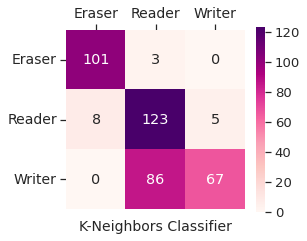

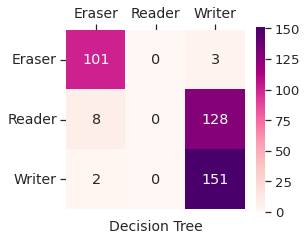

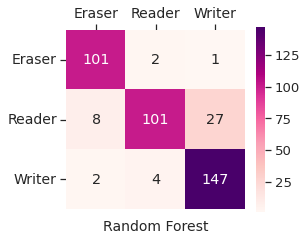

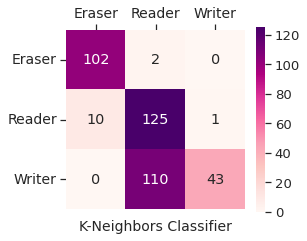

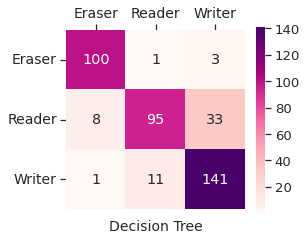

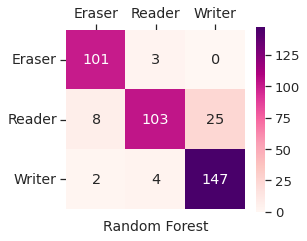

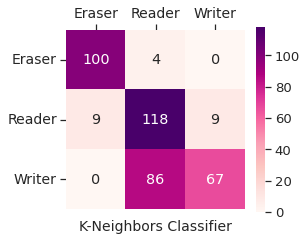

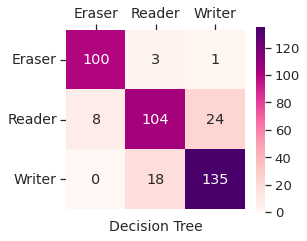

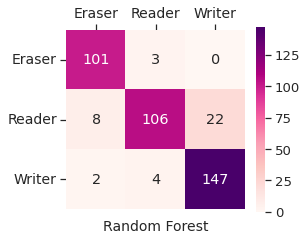

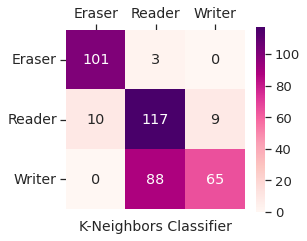

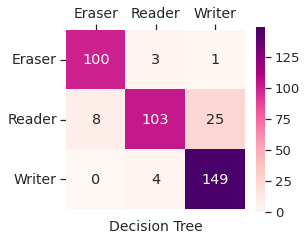

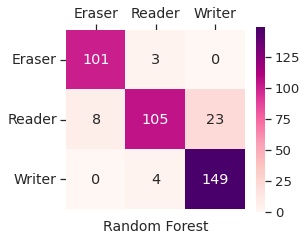

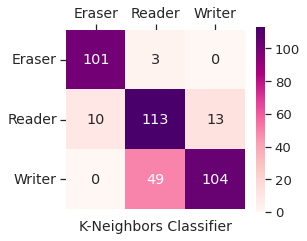

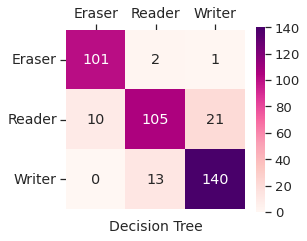

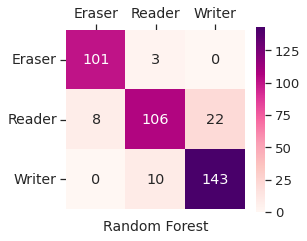

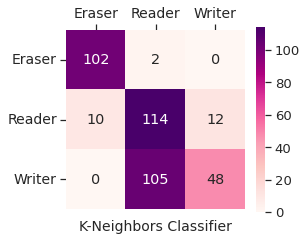

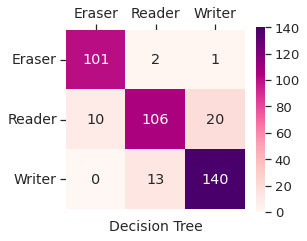

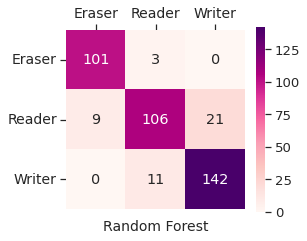

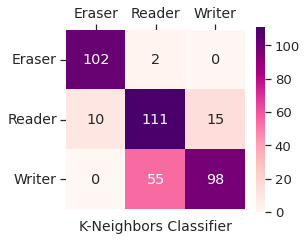

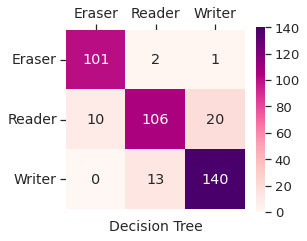

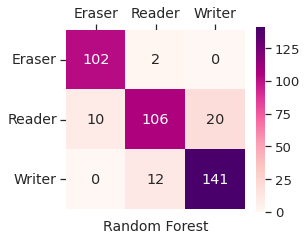

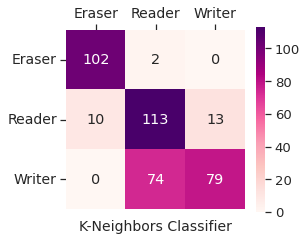

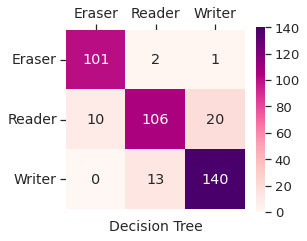

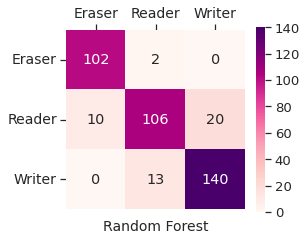

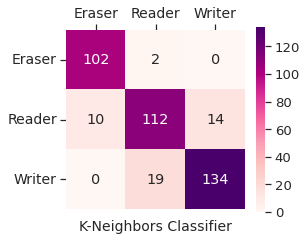

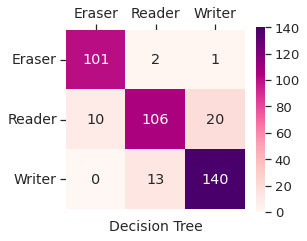

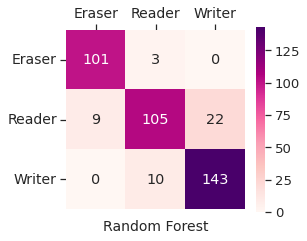

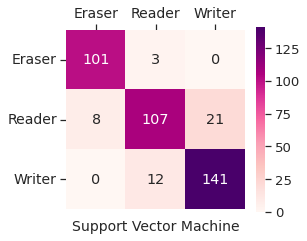

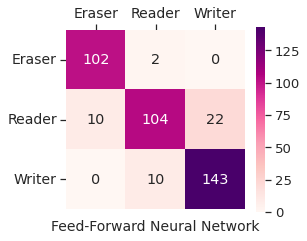

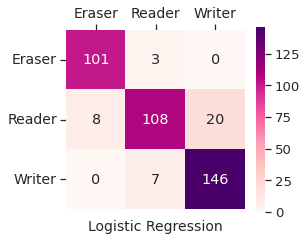

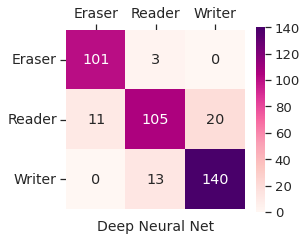

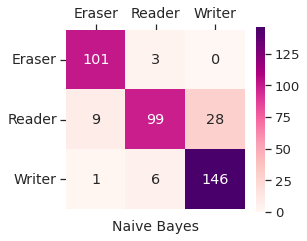

In [ ]:
#Running the ML models on the generated dataset


results = {}
auc = []
accuracy = []
f1 = []
confusion_matrices = []

knn_values = []
dt_values = []
rf_values = []

k = range(1,10)
for i in k:
    knn = knn_kfolds(X_smote, y_smote, 5, i, data, y_, random_state=5)
    dt = decision_tree(X_smote, y_smote, 5, i, data, y_, random_state=5)
    rf = random_forest(X_smote, y_smote, 5, i, data, y_, random_state=5) 

    knn_values.append(knn[0])
    dt_values.append(dt[0])
    rf_values.append(rf[0])

svm = svm_f(X_smote, y_smote, 5, data, y_, random_state=5)
fnn = fnn_f(X_smote, y_smote, 5, data, y_, random_state=5)
lr_s = lr(X_smote, y_smote, 5, data, y_, random_state=5)
dnn = deepNeuralNet(X_smote, y_smote, data, 5, 5)
nb = naiveBayes(X_smote, y_smote, data, 5, 5)

auc.append(max(knn_values))
auc.append(max(rf_values))
auc.append(max(dt_values))
auc.append(fnn[0])
auc.append(lr_s[0])
auc.append(svm[0])
auc.append(nb[0])
auc.append(dnn[0])

accuracy.append(knn[1])
accuracy.append(dt[1])
accuracy.append(rf[1])
accuracy.append(fnn[1])
accuracy.append(lr_s[1])
accuracy.append(svm[1])
accuracy.append(nb[1])
accuracy.append(dnn[1])

f1.append(knn[2])
f1.append(dt[2])
f1.append(rf[2])
f1.append(fnn[2])
f1.append(lr_s[2])
f1.append(svm[2])
f1.append(nb[2])
f1.append(dnn[2])

confusion_matrices.append(knn[3])
confusion_matrices.append(dt[3])
confusion_matrices.append(rf[3])
confusion_matrices.append(fnn[3])
confusion_matrices.append(lr_s[3])
confusion_matrices.append(svm[3])
confusion_matrices.append(nb[3])
confusion_matrices.append(dnn[3])

results['auc'] = auc
#results['accuracy'] = accuracy
results['f1'] = f1
results['accuracy'] = accuracy
results['confusion_matrix'] = confusion_matrices
 
    
    

### Plotting Confusion Matrices

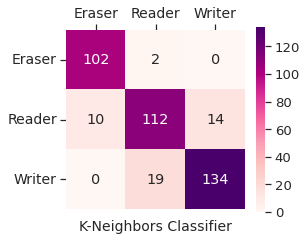

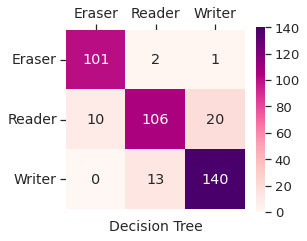

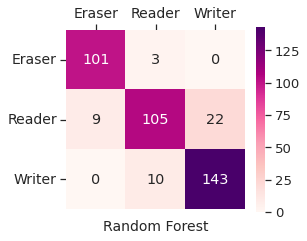

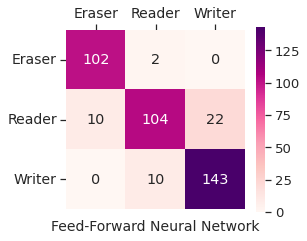

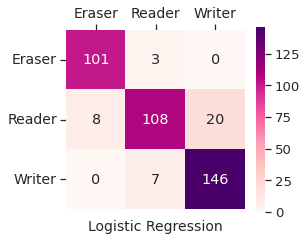

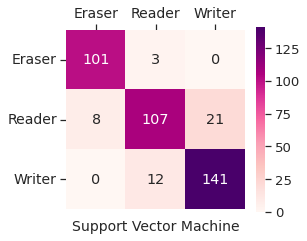

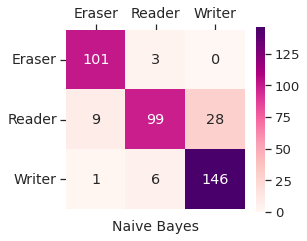

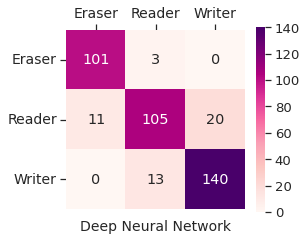

In [ ]:
#Plotting the generated confusion matrices from cell above
sns.set(style="white")
labs=['Eraser','Reader', 'Writer']
models = ["K-Neighbors Classifier", "Decision Tree", "Random Forest",  "Feed-Forward Neural Network", "Logistic Regression", "Support Vector Machine", "Naive Bayes", "Deep Neural Network"]
i = 0
img_file = "confusion_matrices"
for m in results['confusion_matrix']:
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(m, annot=True, square=True, xticklabels=labs, yticklabels=labs, cmap='RdPu', fmt="d",cbar_kws={"shrink": 0.85})
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xticklabels(labs, fontsize=14)
    ax.set_yticklabels(labs, fontsize=14)
    plt.xlabel(models[i], fontsize=14, labelpad=11)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.savefig(img_file + str(i), format="png",bbox_inches='tight', dpi=600)
    i = i + 1